In [2]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [3]:
#database connection settings
import psycopg2

db_name = "traviato_development"
db_host = "localhost"
db_port = "5432"
db_user = "lievgarcia"
db_pwd = "traviato81"

conn = psycopg2.connect(database=db_name, user=db_user, password=db_pwd, host=db_host, port=db_port)

In [4]:
import pandas as pd

columns=['source_id', 'source_name', 'composer', 'work', 'country', 'state', 'city', 'theatre', 
         'date_start', 'date_end', 'premiere_date', 'performance_count', 'composer_country']

cursor = conn.cursor()  
query = "SELECT s.id as source_id, " + \
        "       s.name as source_name, " + \
        "       coalesce(c.name, l.composer) as composer, " + \
        "       coalesce(w.name, l.work) as work, " + \
        "       l.country, " + \
        "       l.state, " + \
        "       l.city, " + \
        "       l.theatre, " + \
        "       l.date_start, " + \
        "       l.date_end, " + \
        "       w.premiere_date, " + \
        "       l.performance_count, " + \
        "       c.country as composer_country " + \
        "from sources s " + \
        "INNER JOIN listings l on s.id = l.source_id " + \
        "LEFT JOIN listing_mappers lm ON l.map_key = lm.map_key " + \
        "LEFT JOIN works w ON lm.work_uri = w.uri " + \
        "LEFT JOIN composers c ON w.composer_id = c.id " + \
        "WHERE source_id IN (4, 8, 13) AND w.uri != 'W1' " + \
        "ORDER BY s.id DESC, l.country, l.state, l.city"
        
cursor.execute(query)

mdf = pd.DataFrame(cursor.fetchall(), columns=columns)
mdf['year'] = mdf.apply(lambda row: row['date_start'].year, axis=1)
mdf['decade'] = mdf.apply(lambda row: 10*int(row['year']/10), axis=1)
mdf[['premiere_date']] = mdf[['premiere_date']].fillna(value=0)
mdf['work_decade'] = mdf.apply(lambda row: 10*int(row['premiere_date']/10), axis=1)
mdf = mdf[mdf['year'] > 2007]
print(mdf.shape)
mdf = mdf[['composer', 'work', 'country', 'state', 'city', 'date_start', 'date_end', 'premiere_date', 'performance_count', 'year', 'decade', 'work_decade', 'composer_country']]
mdf = mdf.drop_duplicates()
print(mdf.shape)

(250410, 16)
(171644, 13)


In [5]:
######################## libraries ########################

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import rc
import matplotlib.ticker as ticker
import numpy as np

import sys
sys.path.append('../../')

from utils.utility_functions import label_top
from utils.utility_functions import get_last_name
from utils.utility_functions import make_dash_zero

##################### CHARTING OPTIONS #####################

# rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
rc('font',**{'family':'serif','serif':['Palatino']})

rc('text', usetex=True)
from cycler import cycler
mpl.rcParams['axes.prop_cycle'] = cycler(color='bgrcmyk')

colors = ['#8a170f', '#8a540f', '#828a0f', '#458a0f', '#0f8a17', '#0f8a54', '#0f828a', '#0f458a', '#170f8a', '#540f8a', '#8a0f82', '#8a0f45']


##################### SOURCES OPTIONS #####################

archival_sources = ['Metropolitan Opera', 'Opera Scotland', 'Royal Opera House', 'Teatro alla Scala', 'Wiener Staatsoper']
commercial_sources_world = ['bachtrack.com','operabase.com','operacritic.com']
commercial_sources_uk = ['Concert-Diary','U.K. Theatre Web']
government_sources = ['National Central Opera Service Reports', 'Opera America']

##############################################################################

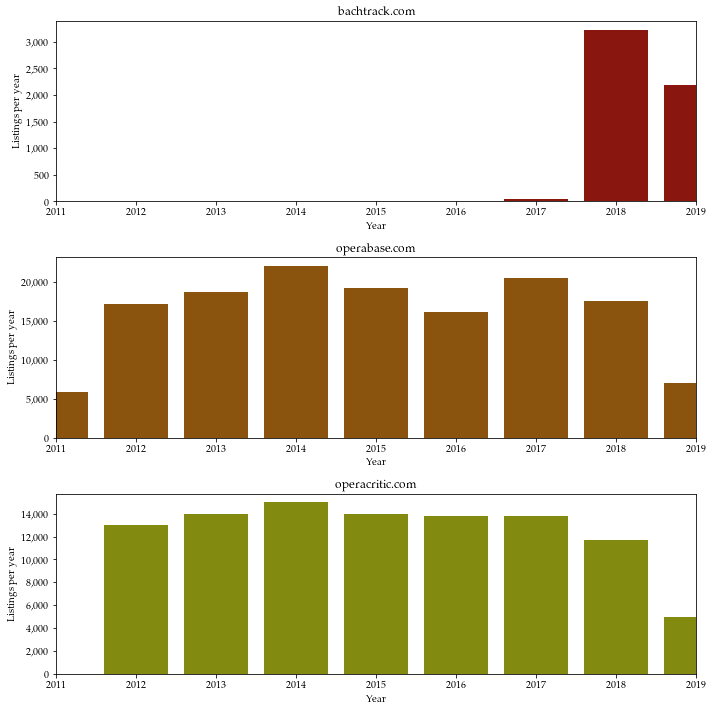

In [18]:
##################### DATA FILTER OPTIONS #####################

sources = commercial_sources_world
num_sources = len(sources)

o_df = mdf.copy()
o_df = o_df[o_df['source_name'].isin(sources)]
o_df = o_df[o_df['work'] != 'Unknown']
o_df = o_df.groupby(['source_name', 'year'])
o_df = o_df.agg({'performance_count': np.sum })
o_df = o_df.reset_index(level=['year'])

###############################################################

##################### CHART BUILDING OPTIONS #####################

fig = plt.figure(figsize=(10, 10))
left_edge, right_edge=None,None

for num, source in enumerate(sources):
    
    dat = o_df.loc[source]    
    dates = dat['year'].values

    ax = plt.subplot(num_sources, 1, num + 1)
    plt.bar(dates, dat['performance_count'], label=source, color=colors[num], linewidth=3)
    plt.xlabel("Year")
    plt.ylabel("Listings per year")
    ax.set_title(source)
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.get_yaxis().set_major_formatter(mpl.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))    
    ax.set_xlim(2011, 2019)    
    
    if left_edge:
        left_edge = min(left_edge, dat.iloc[0]['year'])
        right_edge = max(right_edge, dat.iloc[-1]['year'])        
    else:        
        left_edge = dat.iloc[0]['year']
        right_edge = dat.iloc[-1]['year']
        
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))

# ax.set_xlim(left_edge, right_edge)    
plt.tight_layout()

###############################################################

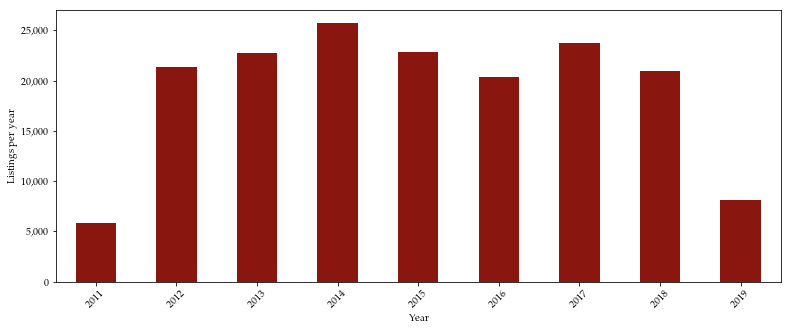

In [60]:
##################### CONSOLIDATED DATA SOURCES #####################

# num_sources = len(sources)

o_df = mdf.copy()
o_df = o_df[o_df['work'] != 'Unknown']

o_df = o_df.groupby(['year'])
o_df = o_df.agg({'performance_count': np.sum })
# o_df = o_df.reset_index(level=['year'])

###############################################################

##################### CHART BUILDING OPTIONS #####################

# fig = plt.figure(figsize=(13, 10))
o_df.plot.bar(figsize=(13, 5), legend=False, color=colors[0])
plt.xlabel("Year")
plt.ylabel("Listings per year")
ax = plt.gca()
plt.xticks(rotation=45)
ax.get_yaxis().set_major_formatter(mpl.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))    

###############################################################

In [61]:
######################## top composers globally ########################

o_df = mdf.copy()
o_df = o_df[o_df['composer'] != 'Unknown']
o_df = o_df[o_df['composer'] != '']

years = o_df['year'].unique().tolist()
years.sort()

for num, year in enumerate(years):
    c_df = o_df[o_df['year']==year]
    c_df = c_df.groupby(['composer'])
    c_df = c_df.agg({'performance_count': np.sum })
    c_df = c_df.sort_values(by=['performance_count'], ascending=False)    
    c_df = c_df.head(10)
    c_df = c_df.reset_index(level=['composer'])  
    c_df[year] = c_df['composer']    
    c_df = c_df[year]
    if num==0:
        df = c_df.copy().to_frame()
    else:
        df = df.join(c_df, how='outer')
    
#If displaying sources as columns
# print('\\textbf{Ranking} & \\textbf{' + ' & \\textbf{'.join(df.columns.values.tolist()) + ' \\\ \midrule ')

# for idx,row in df.iterrows():
#     print(str(idx+1) + ' & ' + ' & '.join(row.values.tolist()) + " \\\\")

df = df.T

for idx,row in df.iterrows():
    values = row.values.tolist()
    values = [get_last_name(c) for c in values ]
    print(str(idx) + ' & ' + ' & '.join(values) + " \\\\")
###############################################################

2011 & Mozart & Puccini & Verdi & Rossini & Wagner & Bizet & Donizetti & Offenbach & Strauss II & Humperdinck \\
2012 & Verdi & Mozart & Puccini & Wagner & Donizetti & Rossini & Bizet & Strauss & Strauss II & Handel \\
2013 & Verdi & Mozart & Puccini & Wagner & Rossini & Donizetti & Strauss II & Bizet & Britten & Tchaikovsky \\
2014 & Verdi & Mozart & Puccini & Rossini & Wagner & Donizetti & Bizet & Strauss & Strauss II & Tchaikovsky \\
2015 & Verdi & Mozart & Puccini & Rossini & Donizetti & Wagner & Bizet & Tchaikovsky & Offenbach & Strauss \\
2016 & Verdi & Puccini & Mozart & Wagner & Rossini & Donizetti & Bizet & Strauss & Tchaikovsky & Strauss II \\
2017 & Verdi & Puccini & Mozart & Rossini & Wagner & Donizetti & Bizet & Tchaikovsky & Strauss II & Offenbach \\
2018 & Verdi & Puccini & Mozart & Rossini & Wagner & Donizetti & Bizet & Bernstein & Strauss II & Tchaikovsky \\
2019 & Verdi & Mozart & Puccini & Wagner & Rossini & Strauss & Donizetti & Bizet & Handel & Offenbach \\


In [62]:
######################## top composers by country ########################

o_df = mdf.copy()
o_df = o_df[o_df['composer'] != 'Unknown']
o_df = o_df[o_df['composer'] != '']

countries_excl = ['Oman','Macedonia','Armenia','South Korea','Egypt','Georgia','Albania','Kyrgyzstan','Mongolia','Singapore',
                  'Bosnia-Herzegovina','Malta','Iceland','Mexico','China','Thailand','Peru','Costa Rica','India','UAE']

o_df = o_df[~o_df['country'].isin(countries_excl)]
countries = o_df['country'].unique().tolist()
countries.sort()

for num, country in enumerate(countries):
    c_df = o_df[o_df['country']==country]
    c_df = c_df.groupby(['composer'])
    c_df = c_df.agg({'performance_count': np.sum })
    c_df = c_df.sort_values(by=['performance_count'], ascending=False)    
    c_df = c_df.head(5)
    c_df = c_df.reset_index(level=['composer'])  
    c_df.index += 1    
    c_df = c_df.rename({'index': 'Ranking'}, axis='columns')
    c_df = c_df.rename({'composer': country}, axis='columns')    
#     print(c_df.head())
#     c_df = c_df.set_index('Ranking')
    c_df = c_df[country]
    
    if num==0:
        df = c_df.copy().to_frame()
    else:
        df = df.join(c_df, how='outer')
        
df = df.T
df      
    
# If displaying sources as columns
# print('\\textbf{Ranking} & \\textbf{' + ' & \\textbf{'.join(df.columns.values.tolist()) + ' \\\ \midrule ')
# for idx,row in df.iterrows():
#     print(str(idx+1) + ' & ' + ' & '.join(row.values.tolist()) + " \\\\")

#For displaying as rows
decades = df.columns.get_values().tolist()
decades = [str(d) for d in decades]

print('l'*len(decades))
print('\\textbf{Country} & \\textbf{' + ' & \\textbf{'.join(decades) + ' \\\ \midrule ')    
for idx,row in df.iterrows():
    values = row.values.tolist()
    values = [get_last_name(c) for c in values ]    
    print(str(idx) + ' & ' + ' & '.join(values) + " \\\\")

###############################################################

lllll
\textbf{Country} & \textbf{1 & \textbf{2 & \textbf{3 & \textbf{4 & \textbf{5 \\ \midrule 
Argentina & Verdi & Mozart & Puccini & Wagner & Rossini \\
Australia & Puccini & Verdi & Mozart & Bizet & Rodgers \\
Austria & Mozart & Verdi & Puccini & Wagner & Strauss II \\
Azerbaijan & Hajibeyov & Verdi & Puccini & Magomayev & Donizetti \\
Belarus & Verdi & Tchaikovsky & Puccini & Mozart & Rimsky-Korsakov \\
Belgium & Verdi & Mozart & Puccini & Wagner & Rossini \\
Bulgaria & Verdi & Puccini & Wagner & Rossini & Kálmán \\
Canada & Verdi & Puccini & Mozart & Rossini & Donizetti \\
Chile & Verdi & Rossini & Mozart & Puccini & Bellini \\
Croatia & Verdi & Puccini & Gotovac & Zajc & Mozart \\
Czech Republic & Verdi & Mozart & Puccini & Dvořák & Smetana \\
Denmark & Puccini & Verdi & Mozart & Rossini & Wagner \\
Estonia & Verdi & Puccini & Kálmán & Bizet & Abraham \\
Finland & Verdi & Puccini & Mozart & Wagner & Janáček \\
France & Mozart & Verdi & Rossini & Puccini & Offenbach \\
Germany & M

In [25]:
######################## top works by country ########################

o_df = mdf.copy()
o_df = o_df[o_df['composer'] != 'Unknown']
o_df = o_df[o_df['composer'] != '']

countries_excl = ['Oman','Macedonia','Armenia','South Korea','Egypt','Georgia','Albania','Kyrgyzstan','Mongolia','Singapore',
                  'Bosnia-Herzegovina','Malta','Iceland','Mexico','China','Thailand','Peru','Costa Rica','India','UAE']

o_df = o_df[~o_df['country'].isin(countries_excl)]
countries = o_df['country'].unique().tolist()
countries.sort()

for num, country in enumerate(countries):
    c_df = o_df[o_df['country']==country]
    c_df = c_df.groupby(['work'])
    c_df = c_df.agg({'performance_count': np.sum })
    c_df = c_df.sort_values(by=['performance_count'], ascending=False)    
    c_df = c_df.head(4)
    c_df = c_df.reset_index(level=['work'])  
    c_df.index += 1    
    c_df = c_df.rename({'index': 'Ranking'}, axis='columns')
    c_df = c_df.rename({'work': country}, axis='columns')    
#     print(c_df.head())
#     c_df = c_df.set_index('Ranking')
    c_df = c_df[country]
    
    if num==0:
        df = c_df.copy().to_frame()
    else:
        df = df.join(c_df, how='outer')
        
df = df.T
df      
    
# If displaying sources as columns
# print('\\textbf{Ranking} & \\textbf{' + ' & \\textbf{'.join(df.columns.values.tolist()) + ' \\\ \midrule ')
# for idx,row in df.iterrows():
#     print(str(idx+1) + ' & ' + ' & '.join(row.values.tolist()) + " \\\\")

works_dict = {
    'La bohème': 'La bohème',
    'Aida': 'Aida',
    'Carmen': 'Carmen',
    'Tosca': 'Tosca',
    'La traviata': 'Traviata',
    'Rigoletto': 'Rigoletto',    
    'Madama Butterfly': 'Butterfly',
    'La damnation de Faust': 'Faust',
    'Il trovatore': 'Il trovatore',
    'The Barber of Seville': 'The Barber of S.',
    'The Marriage of Figaro': 'M. Figaro',
    'The Magic Flute': 'M. Flute',
    'Così fan tutte': 'Così',
    'Don Giovanni': 'Don Giovanni',
    'Turandot': 'Turandot',
    'Der Rosenkavalier': 'Der Rosenkavalier',
    'The Enchanted Island': 'The E. Island',
     "L'elisir d'amore":  "L'elisir",
    'Cavalleria rusticana': 'Cavalleria',
    'Les Huguenots': 'Les Huguenots',
    'The Flying Dutchman': 'The F. Dutchman',
    'Fidelio': 'Fidelio',
    'Sweeney Todd: The Demon Barber of Fleet Street': 'Sweeney Todd',
    'Hexe Hillary geht in die Oper': 'Hexe Hillary',
    "L'enfant et les sortilèges": "L'enfant et les s.",
    "Les contes d'Hoffmann": 'Hoffmann',
    'The Nightingale of Gorenjska': 'N. of Gorenjska',
    'Ero s onoga svijeta': 'Ero',
    'Le notti delle streghe': 'Le notti delle s.',
    'Postcard from Morocco': 'P. from Morocco',
    'Lucia di Lammermoor': 'Lucia di L.',
    'Little Red Riding Hood': 'L.R. Riding Hood'
}

def shorten_name(text):
    try:
        text=works_dict[text]
    except:
        None
    return text

#For displaying as rows
decades = df.columns.get_values().tolist()
decades = [str(d) for d in decades]

print('l'*len(decades))
print('\\textbf{Country} & \\textbf{' + ' & \\textbf{'.join(decades) + ' \\\ \midrule ')    
for idx,row in df.iterrows():
    values = row.values.tolist()
    values = [shorten_name(c) for c in values ]    
    print(str(idx) + ' & ' + ' & '.join(values) + " \\\\")

###############################################################

llll
\textbf{Country} & \textbf{1 & \textbf{2 & \textbf{3 & \textbf{4 \\ \midrule 
Argentina & Traviata & La bohème & Così & Werther \\
Australia & La bohème & Butterfly & Carmen & My Fair Lady \\
Austria & M. Flute & Carmen & Die Fledermaus & Countess Maritza \\
Azerbaijan & Leyli and Majnun & Traviata & Asli and Kerem & Il tabarro \\
Belarus & Carmen & Eugene Onegin & Traviata & Iolanta \\
Belgium & M. Flute & Otello & Don Giovanni & Carmen \\
Bulgaria & Traviata & Countess Maritza & Tosca & Aida \\
Canada & La bohème & Tosca & The Barber of S. & Butterfly \\
Chile & Don Giovanni & The Barber of S. & Aida & M. Flute \\
Croatia & Ero & Nikola Šubić Zrinski & Hexe Hillary & La bohème \\
Czech Republic & Rusalka & Traviata & Carmen & Don Giovanni \\
Denmark & La bohème & Traviata & Tosca & M. Figaro \\
Estonia & Countess Maritza & Carmen & Ball at the Savoy & Traviata \\
Finland & M. Flute & M. Figaro & Traviata & Tosca \\
France & Traviata & Don Giovanni & Carmen & M. Flute \\
Germany 

(array([ 2010.,  2011.,  2012.,  2013.,  2014.,  2015.,  2016.,  2017.,
         2018.,  2019.,  2020.]), <a list of 11 Text xticklabel objects>)

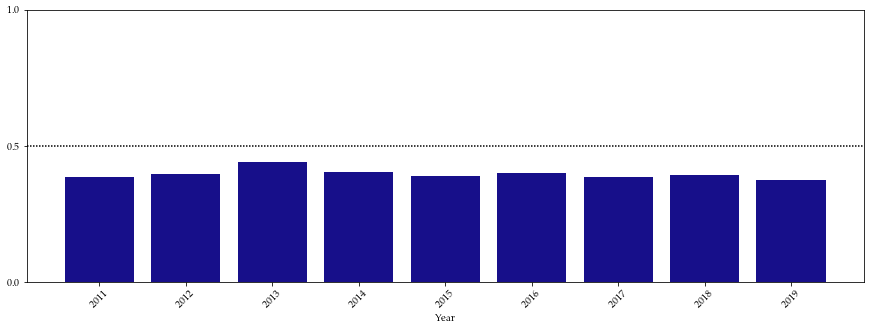

In [63]:
#################### top composers share of repertoire ####################

o_df = mdf.copy()
o_df = o_df[o_df['work'] != 'Unknown']
o_df = o_df[o_df['composer'] != '']

years = o_df['year'].unique().tolist()
years.sort()

for num, year in enumerate(years):    
    dat = o_df[o_df['year']==year]
    c_df = dat.groupby(['composer'])
    c_df = c_df.agg({'performance_count': np.sum })
    top_composers = list(c_df.sort_values(by=['performance_count'], ascending=False).index.values[0:5])    
    o_df['composer'] = o_df.apply(lambda row: label_top(row['year'], year, row['composer'], top_composers), axis=1)
    
c_df = o_df.groupby(['year', 'composer']).agg({'performance_count': np.sum })
c_df = c_df.groupby(level = ['year']).transform(lambda x: x/x.sum())
c_df = c_df.reset_index(level=['year', 'composer'])

fig = plt.figure(figsize=(15, 5))

dat = c_df[c_df['composer']=='Top']
dates = dat['year'].values
plt.bar(dates, dat['performance_count'], color=colors[num], linewidth=3)

axes = plt.gca()
axes.set_ylim([0,1])
axes.axhline(y=.5, dashes=[1, 1], color='#000000')
axes.yaxis.set_major_locator(ticker.MultipleLocator(0.5))
axes.xaxis.set_major_locator(ticker.MultipleLocator(1))

plt.xlabel("Year")
ax = plt.gca()
plt.xticks(rotation=45)

###############################################################

In [6]:
######################## conservativeness and innovation ########################
sources = archival_sources
# sources = ['Metropolitan Opera']

o_df = mdf.copy()
o_df = o_df[o_df['source_name'].isin(sources)]
o_df = o_df[o_df['work_decade']!=0]
o_df = o_df[o_df['year']<2019]

o_df['total_age_works'] = o_df.apply(lambda row: row['performance_count']*(row['year']-row['premiere_date']), axis=1)

for source in sources:
    c_df = o_df[o_df['source_name']==source]
    c_df = c_df.groupby(['decade'])
    c_df = c_df.agg({'total_age_works': np.sum, 'performance_count': 'sum', 'premiere_date': np.max })
    c_df['conservativeness'] = c_df.apply(lambda row: row['total_age_works']/row['performance_count'], axis=1)
    c_df['innovation'] = c_df.apply(lambda row: max(row.name - row['premiere_date'], 0), axis=1)
    c_df = c_df[['conservativeness', 'innovation']]
    print(source)
    print('-----')    
    for idx,row in c_df.iterrows():
        values = row.values.tolist()
        values = [str(int(c)) for c in values ]
        print(str(idx) + ' & ' + ' & '.join(values) + " \\\\")
    print('-----')    

Metropolitan Opera
-----
1880 & 35 & 0 \\
1890 & 43 & 0 \\
1900 & 42 & 0 \\
1910 & 43 & 0 \\
1920 & 51 & 0 \\
1930 & 66 & 0 \\
1940 & 82 & 0 \\
1950 & 89 & 0 \\
1960 & 96 & 0 \\
1970 & 108 & 0 \\
1980 & 116 & 23 \\
1990 & 128 & 0 \\
2000 & 136 & 0 \\
2010 & 139 & 0 \\
-----
Opera Scotland
-----
1950 & 93 & 0 \\
1960 & 104 & 0 \\
1970 & 123 & 0 \\
1980 & 121 & 0 \\
1990 & 133 & 0 \\
2000 & 138 & 0 \\
2010 & 149 & 0 \\
-----
Royal Opera House
-----
1940 & 84 & 0 \\
1950 & 84 & 0 \\
1960 & 87 & 0 \\
1970 & 97 & 0 \\
1980 & 113 & 0 \\
1990 & 128 & 0 \\
2000 & 132 & 0 \\
2010 & 149 & 0 \\
-----
Teatro alla Scala
-----
1940 & 64 & 44 \\
1950 & 101 & 0 \\
1960 & 101 & 0 \\
1970 & 125 & 0 \\
1980 & 114 & 0 \\
1990 & 139 & 9 \\
2000 & 131 & 0 \\
2010 & 153 & 0 \\
-----
Wiener Staatsoper
-----
1860 & 40 & 7 \\
1870 & 28 & 0 \\
1880 & 39 & 0 \\
1890 & 40 & 0 \\
1900 & 46 & 0 \\
1910 & 43 & 0 \\
1920 & 48 & 0 \\
1930 & 56 & 0 \\
1940 & 78 & 0 \\
1950 & 93 & 0 \\
1960 & 107 & 3 \\
1970 & 111 & 0 \\

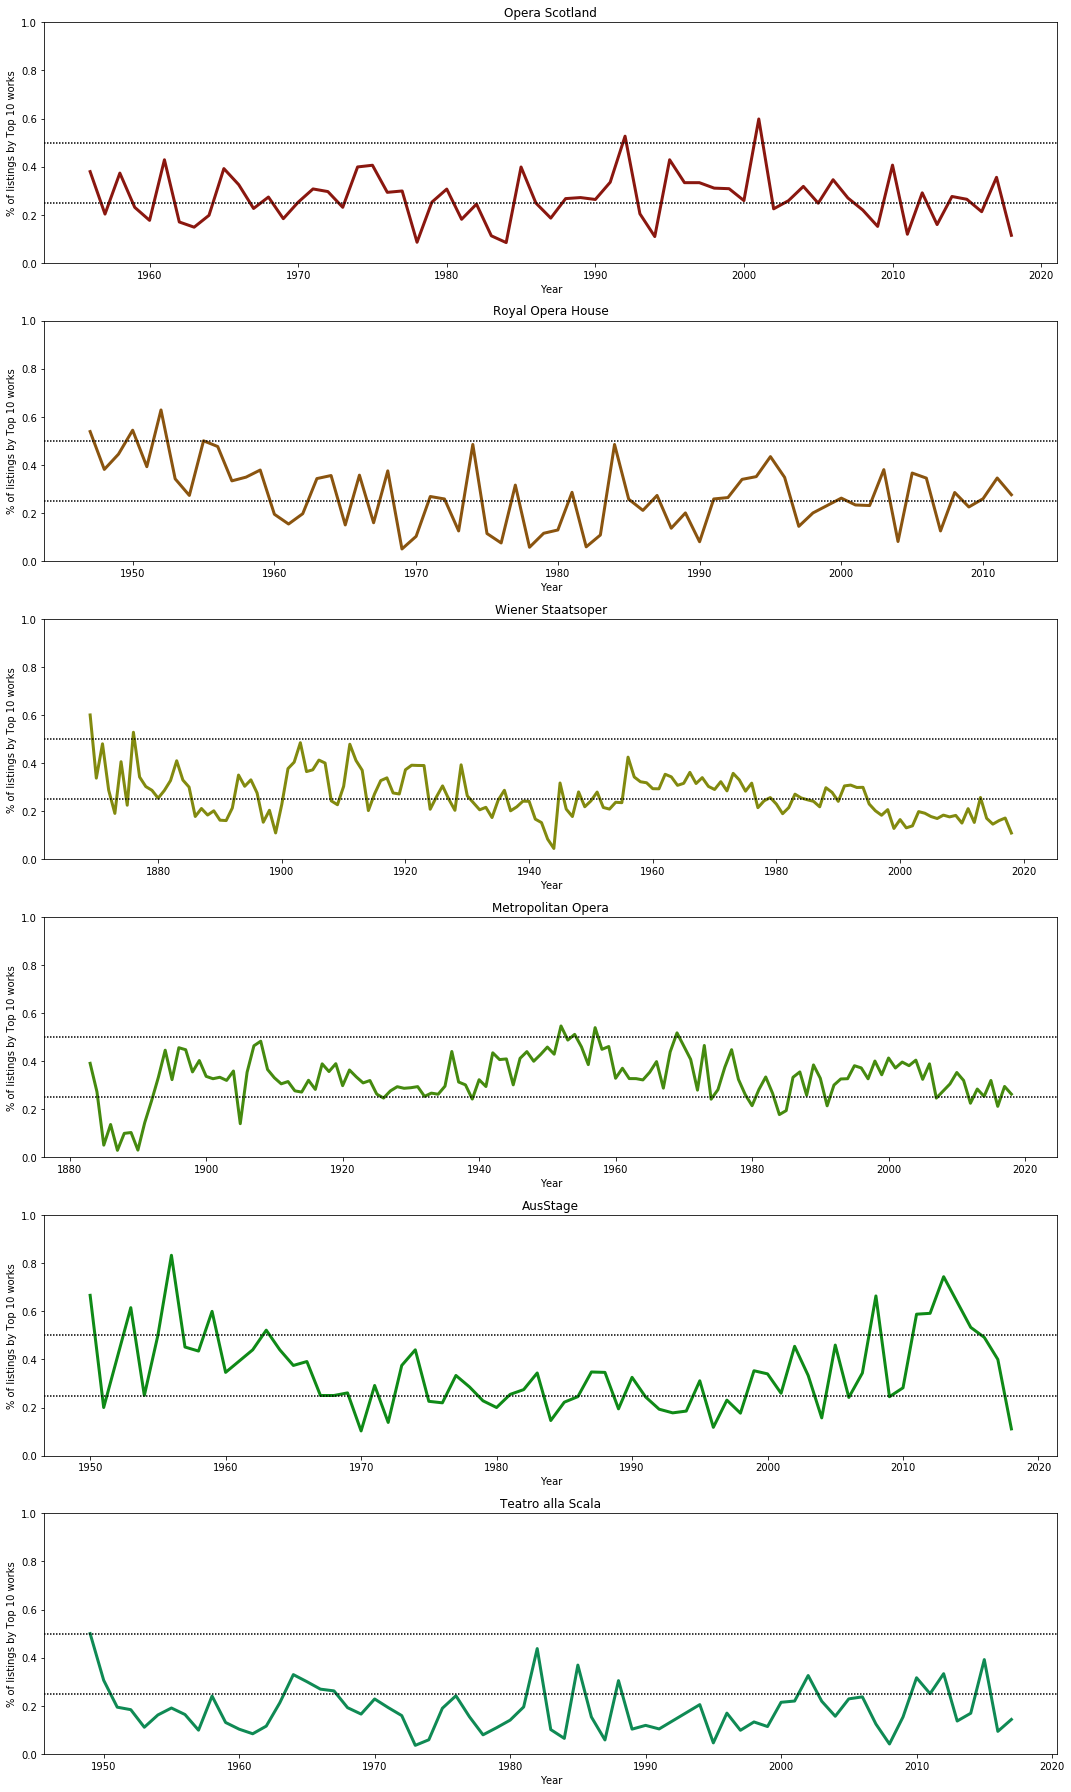

In [6]:
######################## top works ########################

%matplotlib inline

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import rc
import numpy as np

def label_top(source, target_source, value, top_values):
    if source == target_source:
        if value in top_values:
            return 'Top'
        else:
            return 'Other'
    else:
        return value
        
archival_sources = ['AusStage', 'Metropolitan Opera', 'Opera Scotland', 'Royal Opera House', 'Teatro alla Scala', 'Wiener Staatsoper']
commercial_sources = ['Concert-Diary','U.K. Theatre Web','bachtrack.com','operabase.com','operacritic.com']
government_sources = ['National Central Opera Service Reports', 'Opera America']

sources = archival_sources
colors = ['#8a170f', '#8a540f', '#828a0f', '#458a0f', '#0f8a17', '#0f8a54', '#0f828a', '#0f458a', '#170f8a', '#540f8a', '#8a0f82', '#8a0f45']

o_df = mdf.copy()
o_df = o_df[o_df['source_name'].isin(sources)]
o_df = o_df[o_df['work'] != 'Unknown']
o_df = o_df[o_df['work'] != '']
# o_df = o_df[o_df['year'] > 1999]
o_df = o_df[o_df['year'] < 2019]

for source in sources:
    dat = o_df[o_df['source_name']==source]
    c_df = dat.groupby(['work'])
    c_df = c_df.agg({'performance_count': np.sum })
    top_works = list(c_df.sort_values(by=['performance_count'], ascending=False).index.values[0:10])    
    o_df['work'] = o_df.apply(lambda row: label_top(row['source_name'], source, row['work'], top_works), axis=1)
    
c_df = o_df.groupby(['source_name', 'year', 'work']).agg({'performance_count': np.sum })
c_df = c_df.groupby(level = ['source_name', 'year']).transform(lambda x: x/x.sum())

c_df = c_df.reset_index(level=['year', 'work'])

sources = c_df.index.get_level_values('source_name').get_values()
sources = list(set(sources))
num_sources = len(sources)

fig = plt.figure(figsize=(15, 25))

for num, source in enumerate(sources):
    
    dat = c_df.loc[source]    
    dat = dat[dat['work']=='Top']
    dates = dat['year'].values

    ax = plt.subplot(num_sources, 1, num + 1)
    plt.plot(dates, dat['performance_count'], label=source, color=colors[num], linewidth=3)
    plt.xlabel("Year")
    plt.ylabel("% of listings by Top 10 works")
    ax.set_title(source)
    
    axes = plt.gca()
    axes.set_ylim([0,1])
    axes.axhline(y=.5, dashes=[1, 1], color='#000000')
    axes.axhline(y=.25, dashes=[1, 1], color='#000000')    

plt.tight_layout()

###############################################################

(array([ 1500.,  1600.,  1700.,  1800.,  1900.,  2000.,  2100.]),
 <a list of 7 Text xticklabel objects>)

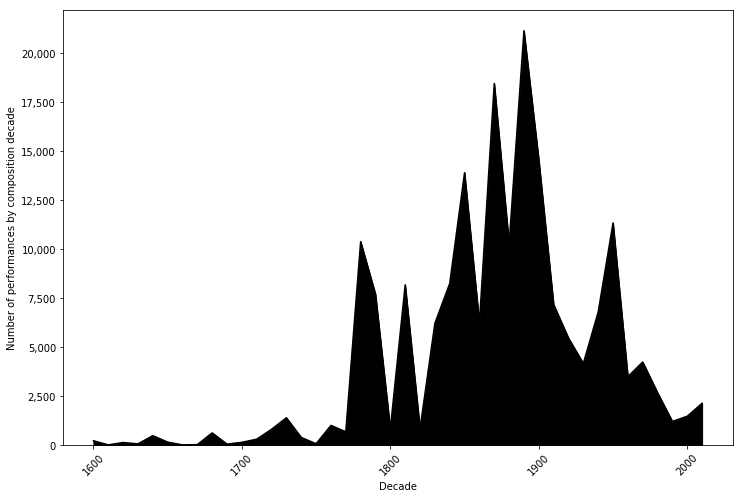

In [467]:
%matplotlib inline

######################## top composers chart ########################

import sys
sys.path.append('../../')

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import rc
import numpy as np

from utils.utility_functions import label_top
        
archival_sources = ['AusStage', 'Metropolitan Opera', 'Opera Scotland', 'Royal Opera House', 'Teatro alla Scala', 'Wiener Staatsoper']
commercial_sources = ['Concert-Diary','U.K. Theatre Web','bachtrack.com','operabase.com','operacritic.com']
government_sources = ['National Central Opera Service Reports', 'Opera America']

sources = government_sources
colors = ['#8a170f', '#8a540f', '#828a0f', '#458a0f', '#0f8a17', '#0f8a54', '#0f828a', '#0f458a', '#170f8a', '#540f8a', '#8a0f82', '#8a0f45']

o_df = mdf.copy()
o_df = o_df[o_df['source_name'].isin(sources)]
o_df = o_df[o_df['composer'] != 'Unknown']
o_df = o_df[o_df['composer'] != '']
o_df = o_df[o_df['work_decade']!=0]

decades_dict = { 'work_decade': np.arange(1600, 2020, 10), 'zeros': np.zeros(42) }
d_df = pd.DataFrame.from_dict(decades_dict)
d_df = d_df.set_index('work_decade')

c_df = o_df.groupby(['work_decade'])
c_df = c_df.agg({'performance_count': np.sum })
c_df = c_df.sort_values(by=['performance_count'], ascending=False)    
c_df = c_df.sort_index()

c_df = c_df.join(d_df, how='outer')
c_df['performance_count'] = c_df['performance_count'].fillna(value=0)
c_df = c_df[['performance_count']]

c_df.plot.area(color='#000000', figsize=(12, 8), legend=False)
plt.ylabel('Number of performances by composition decade')
plt.xlabel('Decade')
ax = plt.gca()
ax.get_yaxis().set_major_formatter(mpl.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
plt.xticks(rotation=45)

# plt.plot(df['Year'], df['performance_count'], '-o', color='orange')


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:35: FutureWarning: 'work_decade' is both an index level and a column label.
Defaulting to column, but this will raise an ambiguity error in a future version


(array([ 1400.,  1500.,  1600.,  1700.,  1800.,  1900.,  2000.,  2100.]),
 <a list of 8 Text xticklabel objects>)

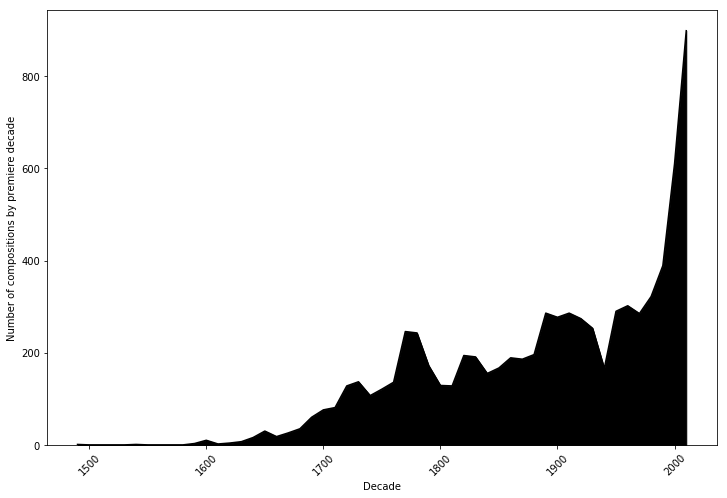

In [468]:
%matplotlib inline

######################## works premieres ########################
import sys
sys.path.append('../../')

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import rc
import numpy as np
import pandas as pd

from utils.utility_functions import label_top

columns=['work', 'premiere_date']

cursor = conn.cursor()  
query = "SELECT w.name, " + \
        "       w.premiere_date " + \
        "from works w "
        
cursor.execute(query)

wdf = pd.DataFrame(cursor.fetchall(), columns=columns)
wdf[['premiere_date']] = wdf[['premiere_date']].fillna(value=0)
wdf['work_decade'] = wdf.apply(lambda row: 10*int(row['premiere_date']/10), axis=1)
    
o_df = wdf.copy()
o_df = o_df[o_df['work_decade']!=0]

decades_dict = { 'work_decade': np.arange(1490, 2020, 10), 'zeros': np.zeros(len(np.arange(1490, 2020, 10))) }
d_df = pd.DataFrame.from_dict(decades_dict)
d_df = d_df.set_index('work_decade')

c_df = o_df.groupby(['work_decade'])
c_df = c_df.agg({'work_decade': 'count' })
c_df = c_df.sort_values(by=['work_decade'], ascending=False)    
c_df = c_df.sort_index()

c_df = c_df.join(d_df, how='outer')
c_df['works_count'] = c_df['work_decade'].fillna(value=0)
c_df = c_df[['work_decade']]

c_df.plot.area(color='#000000', figsize=(12, 8), legend=False)
plt.ylabel('Number of compositions by premiere decade')
plt.xlabel('Decade')
ax = plt.gca()
ax.get_yaxis().set_major_formatter(mpl.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
plt.xticks(rotation=45)

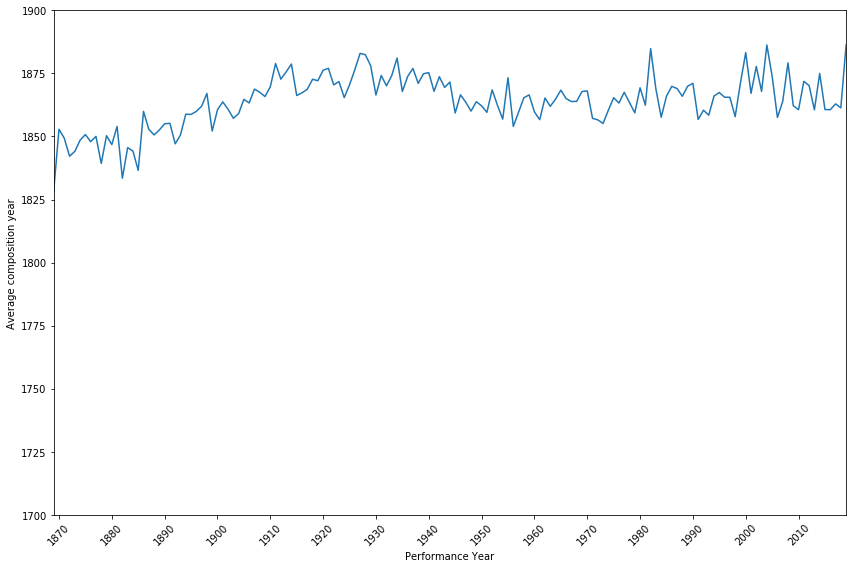

In [481]:
%matplotlib inline

######################## works premieres ########################
import sys
sys.path.append('../../')

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import rc
import numpy as np
import pandas as pd
import matplotlib.ticker as ticker

from utils.utility_functions import label_top
    
    
archival_sources = ['AusStage', 'Metropolitan Opera', 'Opera Scotland', 'Royal Opera House', 'Teatro alla Scala', 'Wiener Staatsoper']
commercial_sources = ['Concert-Diary','U.K. Theatre Web','bachtrack.com','operabase.com','operacritic.com']
government_sources = ['National Central Opera Service Reports', 'Opera America']

sources = archival_sources

o_df = mdf.copy()
o_df = o_df[o_df['source_name'].isin(sources)]
o_df = o_df[o_df['work_decade']!=0]


o_df['aggregate_year'] = o_df.apply(lambda row: row['performance_count']*row['premiere_date'], axis=1)

c_df = o_df.groupby(['year'])
c_df = c_df.agg({'aggregate_year': np.sum, 'work': 'count' })
c_df['average_premiere_year'] = c_df.apply(lambda row: row['aggregate_year']/row['work'], axis=1)
c_df = c_df[['average_premiere_year']]
left_edge = c_df.index[0]
right_edge = c_df.index[-1]

c_df.plot.line(figsize=(12, 8), legend=False)

plt.ylabel('Average composition year')
plt.xlabel('Performance Year')
ax = plt.gca()
ax.set_ylim([1700,1900])
ax.set_xlim(left_edge, right_edge)
ax.xaxis.set_major_locator(ticker.MultipleLocator(10))

# ax.get_yaxis().set_major_formatter(mpl.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
plt.xticks(rotation=45)
plt.tight_layout()

In [477]:
c_df.index[0]

1869

In [6]:
######################## average premiere year ########################    

o_df = mdf.copy()
o_df = o_df[o_df['composer'] != 'Unknown']
o_df = o_df[o_df['composer'] != '']

countries_excl = ['Oman','Macedonia','Armenia','South Korea','Egypt','Georgia','Albania','Kyrgyzstan','Mongolia','Singapore',
                  'Bosnia-Herzegovina','Malta','Iceland','Mexico','China','Thailand','Peru','Costa Rica','India','UAE']

o_df = o_df[~o_df['country'].isin(countries_excl)]
countries = o_df['country'].unique().tolist()
countries.sort()

o_df['aggregate_year'] = o_df.apply(lambda row: row['performance_count']*row['premiere_date'], axis=1)
o_df['aggregate_year_own'] = o_df.apply(lambda row: row['performance_count']*row['premiere_date'] if row['country']==row['composer_country'] else 0, axis=1)
o_df['performance_count_all'] = o_df.apply(lambda row: row['performance_count'] if row['premiere_date']!=0 else 0, axis=1)
o_df['performance_count_own'] = o_df.apply(lambda row: row['performance_count'] if (row['country']==row['composer_country'] and row['premiere_date']!=0) else 0, axis=1)
# o_df

c_df = o_df.groupby(['country'])
c_df = c_df.agg({'aggregate_year': np.sum, 'aggregate_year_own': np.sum, 'performance_count_all': 'sum', 'performance_count_own': 'sum', 'performance_count': np.sum })
c_df['average_premiere_year'] = c_df.apply(lambda row: row['aggregate_year']/row['performance_count_all'], axis=1)
c_df['average_premiere_year_own'] = c_df.apply(lambda row: row['aggregate_year_own']/row['performance_count_own'], axis=1)
# c_df = c_df.reset_index(level=['country'])

c_df = c_df[['average_premiere_year', 'average_premiere_year_own', 'performance_count']]
c_df = c_df.fillna(value=0)


c_df

###############################################################

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in double_scalars


,average_premiere_year,average_premiere_year_own,performance_count
country,,,
Argentina,1867.431250,0.000000,492
Australia,1887.053700,0.000000,2445
Austria,1877.292782,1846.846315,10183
Azerbaijan,1893.643478,1920.675676,117
Belarus,1868.741758,2012.000000,560
Belgium,1867.548159,1929.474576,2176
Bulgaria,1871.071374,1949.724138,1359
Canada,1868.309524,1991.566038,1571
Chile,1865.975904,0.000000,249


Text(0.5,0,'Average yremiere year')

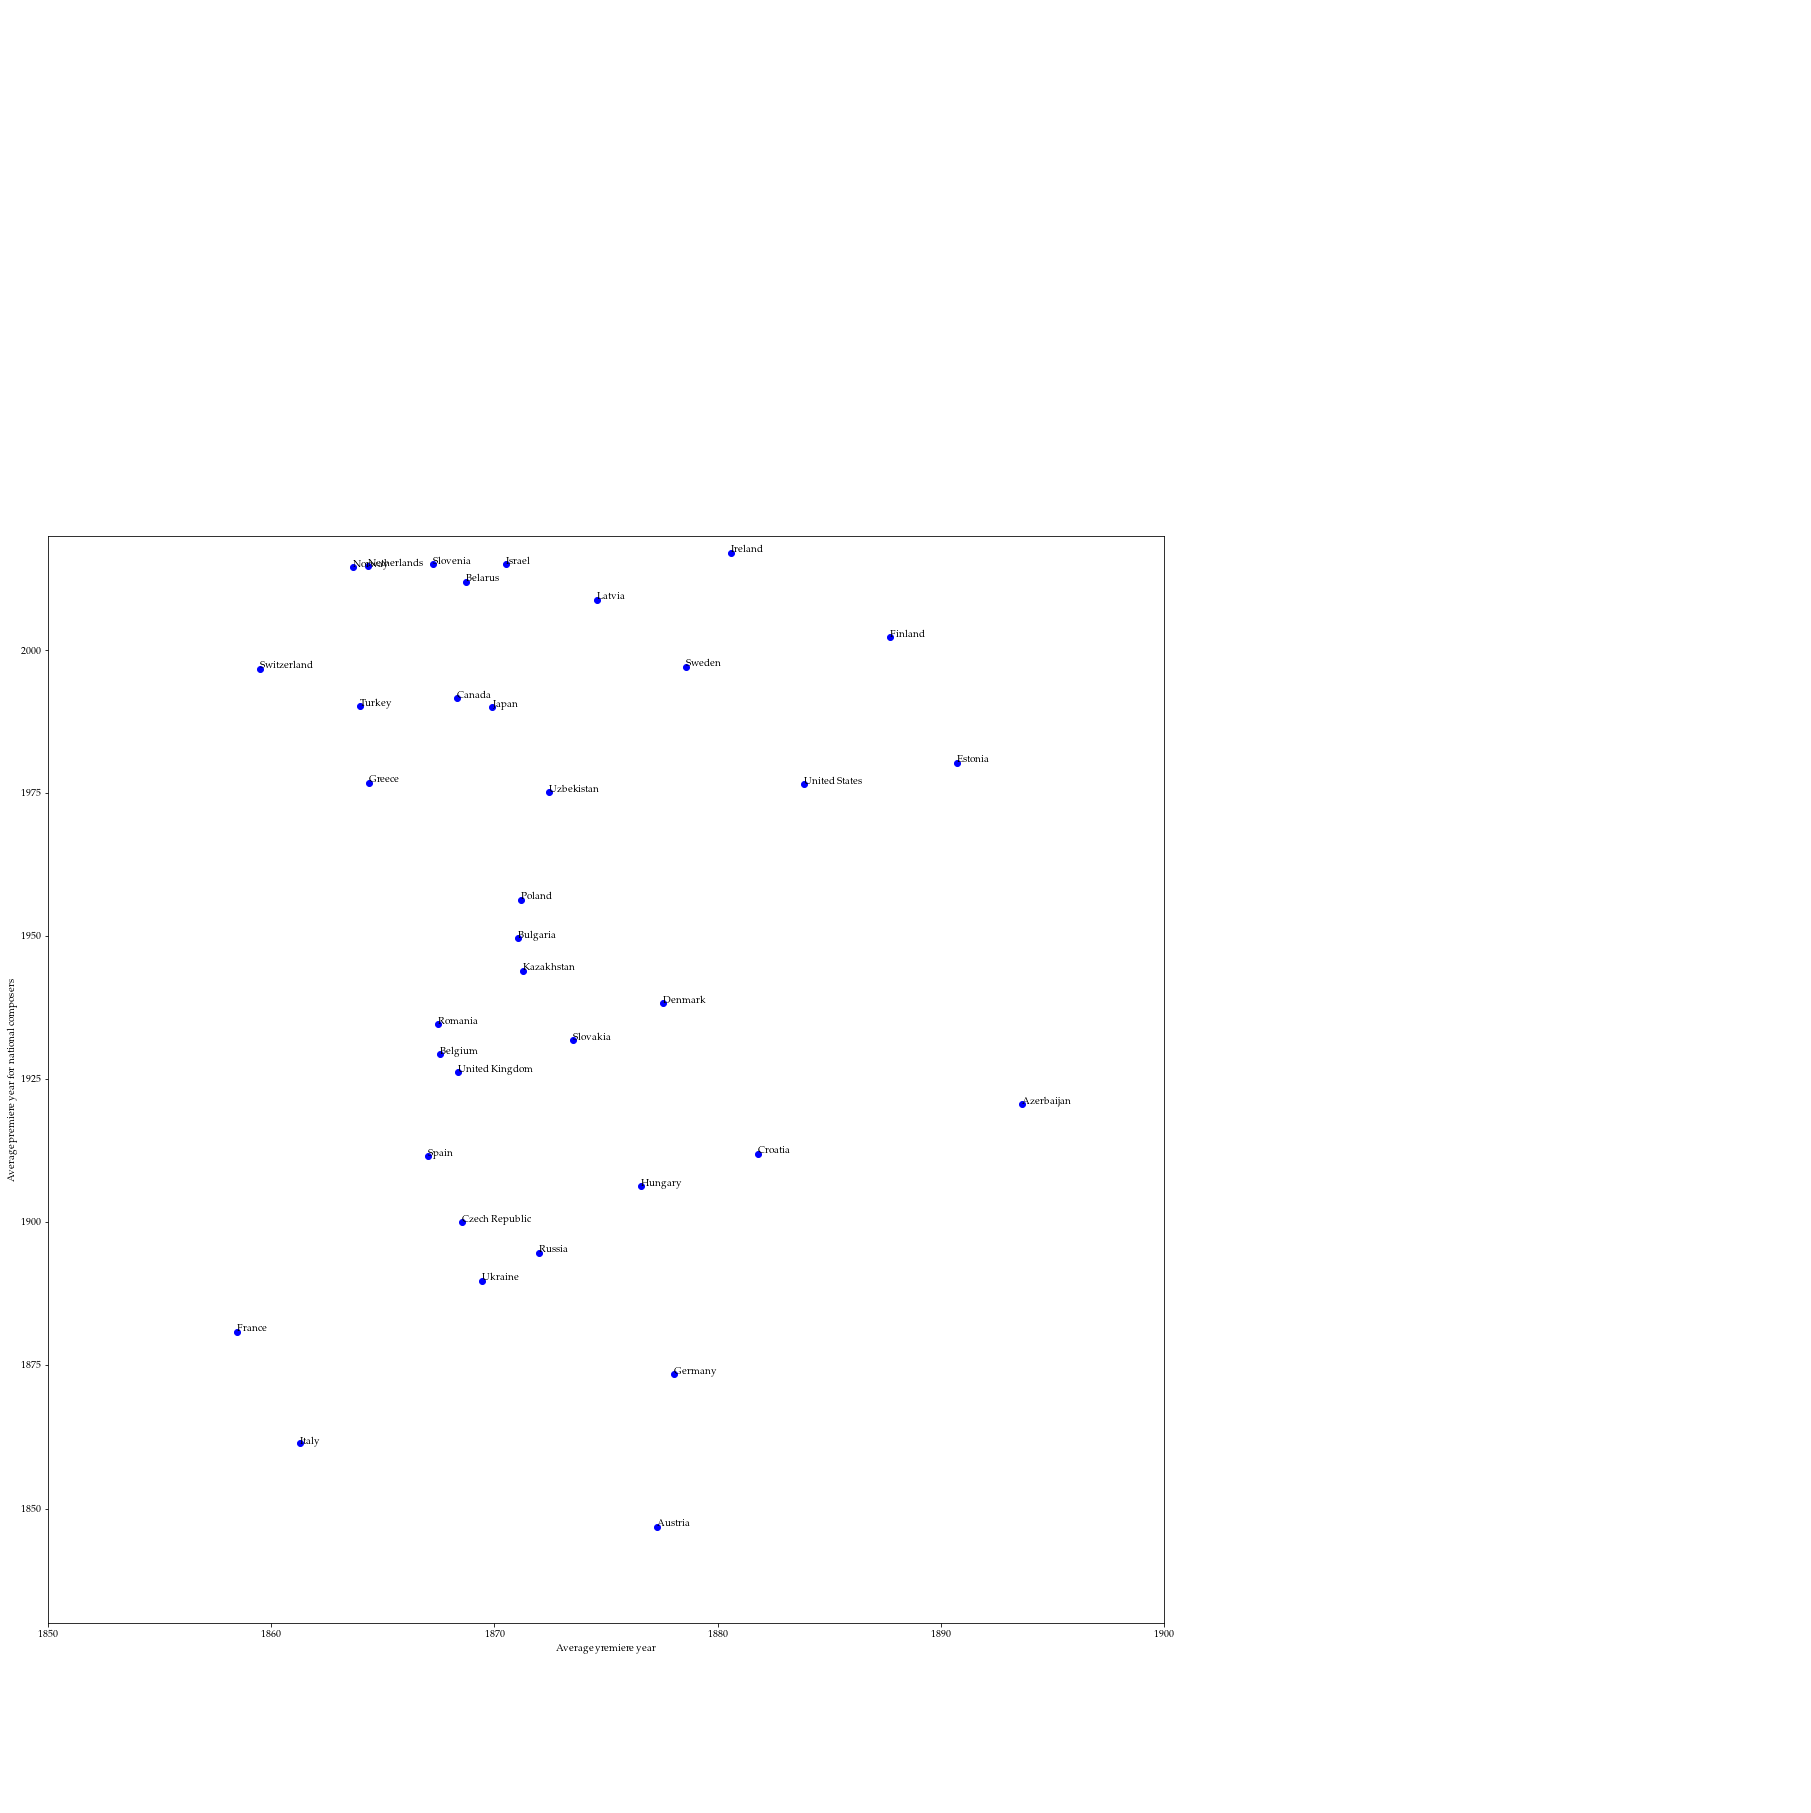

In [50]:
# ax = c_df.plot.scatter(x='average_premiere_year', 
#                        y=u'average_premiere_year_own', 
#                        figsize=(8, 8), 
#                        legend=False)

# plt.ylabel('Average premiere year for national composers')
# plt.xlabel('Average yremiere year')
# ax = plt.gca()
# ax.set_ylim([1830,2020])
# ax.set_xlim([1850,1900])
# ax.xaxis.set_major_locator(ticker.MultipleLocator(10))
# plt.xticks(rotation=45)
# plt.tight_layout()

# ax.plot(ax.get_xlim(), ax.get_ylim(), ls="--", c=".3")

# for i, txt in enumerate(c_df.index.values.tolist()):
#     ax.annotate(txt, (c_df.loc[txt]['average_premiere_year'], c_df.loc[txt]['average_premiere_year_own']))
    
fig, ax = plt.subplots(figsize=(20, 20))
# fig, ax = plt.figure(figsize=(10, 10))

ax.scatter(c_df['average_premiere_year'].tolist(), c_df['average_premiere_year_own'].tolist())

for i, row in c_df.iterrows():
    ax.annotate(row.name, (row['average_premiere_year'], row['average_premiere_year_own']))
    axes = plt.gca()
    axes.set_ylim([1830,2020])
    axes.set_xlim([1850,1900])

plt.ylabel('Average premiere year for national composers')
plt.xlabel('Average yremiere year')
# ax = plt.gca()

    

In [ ]:
for i, row in c_df.iterrows():
    x = row['average_premiere_year']
    y = row['average_premiere_year_own']
    plt.plot(x, y, 'bo')
    plt.figsize=(10, 10)
    plt.text(x, y, row.name, fontsize=12)

plt.xlim((0, 10))
plt.ylim((0, 10))



# plt.show()

(0, 10)

In [10]:
plt

<module 'matplotlib.pyplot' from '/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/matplotlib/pyplot.py'>

In [77]:
#################### top composers share of repertoire ####################

o_df = mdf.copy()
o_df = o_df[o_df['composer'] != 'Unknown']
o_df = o_df[o_df['composer'] != '']

countries_excl = ['Oman','Macedonia','Armenia','South Korea','Egypt','Georgia','Albania','Kyrgyzstan','Mongolia','Singapore',
                  'Bosnia-Herzegovina','Malta','Iceland','Mexico','China','Thailand','Peru','Costa Rica','India','UAE']

o_df = o_df[~o_df['country'].isin(countries_excl)]
countries = o_df['country'].unique().tolist()
countries.sort()

o_df = o_df.groupby(['country', 'composer']).agg({'performance_count': np.sum })
o_df = o_df.reset_index(level=['country', 'composer'])

for country in countries:
#     print(country)
    dat = o_df[o_df['country']==country]
    c_df = dat.groupby(['composer'])
    c_df = c_df.agg({'performance_count': np.sum })
    top_composers = list(c_df.sort_values(by=['performance_count'], ascending=False).index.values[0:5])    
    o_df['composer'] = o_df.apply(lambda row: label_top(row['country'], country, row['composer'], top_composers), axis=1)
    
c_df = o_df.groupby(['country', 'composer']).agg({'performance_count': np.sum })
c_df = c_df.groupby(level = ['country']).transform(lambda x: x/x.sum())
c_df = c_df.reset_index(level=['composer'])

c_df = c_df[c_df['composer']=='Top']
c_df = c_df.rename({'performance_count': 'Share by Top 5 composers'}, axis='columns')
c_df = c_df[['Share by Top 5 composers']]

share_df = c_df.copy()

##############################################################################

######################## conservativeness  ########################

o_df = mdf.copy()
o_df = o_df[o_df['composer'] != 'Unknown']
o_df = o_df[o_df['composer'] != '']

countries_excl = ['Oman','Macedonia','Armenia','South Korea','Egypt','Georgia','Albania','Kyrgyzstan','Mongolia','Singapore',
                  'Bosnia-Herzegovina','Malta','Iceland','Mexico','China','Thailand','Peru','Costa Rica','India','UAE']

o_df = o_df[~o_df['country'].isin(countries_excl)]
o_df = o_df[o_df['work_decade']!=0]
o_df['total_age_works'] = o_df.apply(lambda row: row['performance_count']*(row['year']-row['premiere_date']), axis=1)

countries = o_df['country'].unique().tolist()
countries.sort()

c_df = o_df.groupby(['country'])
c_df = c_df.agg({'total_age_works': np.sum, 'performance_count': 'sum' })
c_df['conservativeness'] = c_df.apply(lambda row: row['total_age_works']/row['performance_count'], axis=1)
c_df = c_df[['conservativeness']]
c_df = c_df.rename({'conservativeness': 'Conservativeness'}, axis='columns')

##############################################################################

df = share_df.join(c_df, how='outer')
df[['Conservativeness']] /= df[['Conservativeness']].max()
df



,Share by Top 5 composers,Conservativeness
country,,
Argentina,0.457317,0.942383
Australia,0.559509,0.817099
Austria,0.321222,0.879819
Azerbaijan,0.675214,0.771300
Belarus,0.696429,0.935402
Belgium,0.414522,0.940588
Bulgaria,0.595291,0.919034
Canada,0.455124,0.936178
Chile,0.554217,0.951672


(115, 160)

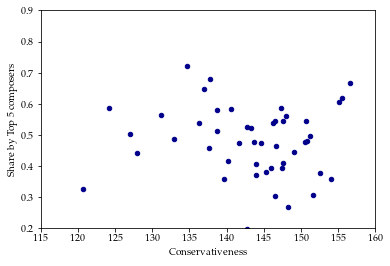

In [73]:

ax1 = df.plot.scatter(x='Conservativeness', y='Share by Top 5 composers', c='DarkBlue')

plt.ylabel('Share by Top 5 composers')
plt.xlabel('Conservativeness')
ax = plt.gca()
ax.set_ylim([.2,.9])
ax.set_xlim([115,160])


-0.071371663101385471